# Evaluation Report - Section Means as Features

The first cell provides a summary of selected parameters and the evaluation ($\rightarrow$ executed after evaluation).

In [66]:
try:
    print_eval_summary()
except:
    pass


    Summary of Evaluation Report

Test data set:
	Subject ID: 	1
	Samples: 	709
	Rep. num.: 	-1
	Exercises: 	-1
	Rotation axes: 	0
	Rot. angles: 	0
	SNR: 		none

Train data set:
	Subject ID(s): 	-1
	Samples: 	6120
	Rep. num.: 	-1
	Exercises: 	-1
	SNR: 		none

Number of sections to split each rep.: 10

Dimensionality reduction: 	PCA (20 PCs)

Parameters for windowing procedure:
	Win. start inc.: 	0.2 s
	Win. stretch inc.: 	0.2 s
	Min. win. length: 	1 s
	Max. win. length: 	5 s
	Filter order: 		6
	Cutoff frequency: 	10 Hz

Parameters for windowing procedure:
	Max. time betw. 2 rep.:	6 s
	Min rep. per block: 	3
	Prob. threshold: 	0.5
	Footprint length: 	3 s

Machine Learning:
	Model: 	RFC
	Param. for grid search cross val.:
		clf__n_estimators: [50, 100, 200]
		clf__criterion: ['gini', 'entropy']
		clf__max_depth: [10, 50, 100]
	Best parameters:
		clf__criterion: gini
		clf__max_depth: 50
		clf__n_estimators: 200
	Best score (gridsearchCV): 	93.38%

	Score on sep. test samples: 	87.73%

	

***
***
***
***
***

***Save the notebook:***

In [67]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

***Convert the notebook to html:***

(Executed in the end.)

In [68]:
try:
    exporter = HTMLExporter()
    output_notebook = nbformat.read('Evaluation_Report.ipynb', as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open('Report_' + file_doc_string  + '.html', 'w', encoding='utf-8').write(output)
except:
    pass

***
***
***
***
***
***Import moduels:***

In [4]:
import pandas as pd
import numpy as np
import datetime
import timeit
import time
from nbconvert import HTMLExporter
import codecs
import nbformat
from pivottablejs import pivot_ui

import sys
sys.path.append('..')  # in order to import modules from the package 'packageMeinhart'
from packageMeinhart import PhysioDataHandler as PDH
from packageMeinhart.functionsMasterProjectMeinhart import print_misclassified_data_points
from packageMeinhart.functionsMasterProjectMeinhart import get_timetable_ex_dict

# Modules for machine learning and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# StandardScaler raises the following warning:
# --> DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
# In order to ignore that:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
%matplotlib inline

## Definition of Parameters

### Number of Sections

***Number of sections to split each exercise repetition:***

In [6]:
number_sections = 10

### Test Subject

***Select the test subject via ID:***

In [7]:
test_subject_id = 1

### Training Subjects

***Subjects (IDs) to consider for training:***

Integer or list of integers.

If all subjects except the test subject shall be considered for training, set parameter to -1.

In [8]:
train_subject_ids = -1

### Repetition Numbers

***Repetition numbers of blocks for testing (of separated samples) or rather training:***

Available repetition numbers: 5, 10, 15

If more than on repetition number shall be selected, use a list (e.g. [5, 10]).

If parameter is set to -1, all repetition numbers are selected.

In [9]:
test_repetition_numbers = -1
train_repetition_numbers = -1

### Exercises

***Exercises for testing (of separated samples) or rather training:***
    
Available exercises: 'RF', 'RO', 'RS', 'LR', 'BC', 'TC', 'MP', 'SA', 'P1', 'P2', 'NE'
    
If more than on exercise shall be selected, use a list (e.g. ['RF', 'BC']).

If parameter is set to -1, all exercises are selected.

In [10]:
test_exercises = -1
train_exercises = -1

### Rotation Test Data

***Axes and angles to rotate the test data:***
    
Available axes: 0, 1, 2 ($\rightarrow$ x, y, z)

Rotation angles must be given in degrees.
    
If sequence of rotations shall be applied, use lists (e.g. [0, 1] for axes and [20, 45] for angles).

NOTE: Rotation is applied to separated test samples as well as to the whole record of the test subject.

In [11]:
rot_axis_test_data = 0
rot_angle_test_data = 0

### Noise

***Noise to be added to test and/or training data:***

Additive White Gaussian Noise (AWGN) with a defined Signal to Noise Ratio (SNR) in decibel is used.

The noise will then be calculated by means of the SNR with regard to each signal of a whole repetition block.

NOTE: Noise is added to separated test samples as well as to the whole record of the test subject.

In [12]:
add_noise_test_data = False
add_noise_train_data = False
snr_db = 10

### PCA

***Principal Component Analysis (PCA) for dimensionality reduction:***

If used, project features to a lower dimensional space.

(Be aware that number of principal components has to be lower than number of features.)

In [13]:
use_PCA_for_dim_reduction = True
number_principal_components = 20

### LDA

***Linear Discriminant Analysis (LDA) for dimensionality reduction:***

Also LDA can be used to project features to a lower dimensional space.

(Number of new features ... number of classes - 1)

In [14]:
use_LDA_for_dim_reduction = False

### Windowing Procedure

***Parameters for windowing procedure:***

Window start increment [s]:

In [15]:
win_start_inc = 0.2

Window stretch increment [s]:

In [16]:
win_stretch_inc = 0.2

Maximum window length [s]:

In [17]:
win_min_len = 1

Minimum window length [s]:

In [18]:
win_max_len = 5

Order of butterworth filter:

In [19]:
butterworth_order = 6

Cutoff frequency of butterworth filter [Hz]:

In [20]:
butterworth_cutoff = 10

### Probability Matrices

***Parameters for the evaluation of probability matrices:***

Maximum time between two peaks (repetitions) of the same repetition block [s]:

In [21]:
max_time_between_peaks = 6

Minimum number of peaks (repetitions) per repetition block:

In [22]:
min_peaks_per_block = 3

Probability threshold in order to accept peaks as exercise repetitions (0 ... 1):

In [23]:
threshold_prob = 0.5

Length of the footprint for a maximum-filter in order to find peaks [s]:

In [24]:
footprint_length = 3

Print individual repetition lengths [s] and predicted probabilities (if True):

In [25]:
print_rep_len_prob = True

### Plotting

***Parameters for plotting of exercise repetition blocks:***

Since it would be too much to plot all exercise repetition blocks, it can be chosen
how many and which blocks shall be plotted. Therefore, the repetition blocks have to be present in a list of strings, where every string consists of the exercise abbreviation and the number of repetitions.

Example: ['RF_5', 'RO_10', 'BC_15'] $\rightarrow$ generates three plots

The second parameter defines the time to plot before and after the selected block in seconds.

In [26]:
plot_exercise_repetition_blocks = ['RF_15','RO_5','RS_10','LR_15','BC_5','TC_10','MP_15','SA_5','P1_10','P2_15']
plot_time_offset_before_and_after = 3 # [s]

### Whole Test Record

***Directory and file-name of csv-file with whole record of the test subject:***

In [27]:
test_subject_dir  = 'E:\Physio_Data\Subject_{:02d}'.format(test_subject_id)
test_subject_file = 'subject{:02d}.csv'.format(test_subject_id)

### Timetables

***Directory and file-name of timetable with the actual exercises:***

In [28]:
timetable_file_dir = 'E:\Physio_Data\Exercise_time_tables'
timetable_file_name = 'Timetable_subject{:02d}.txt'.format(test_subject_id)

### Separated csv-files & Database

***Directory of separated csv-files (repetition blocks) and path of database with information regarding repetitions:***

In [29]:
separated_csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx'
database_path='E:\Physio_Data\DataBase_Physio_with_nonEx.db'

### Sampling Rate

***Sampling rate of recorded signals [Hz]:***

In [30]:
sampling_rate=256 # [Hz]

### Add Info

***Addition information for the file-names to save:***

Test subject ID, number of sections, ML model name and timestamp will automatically be used.

In [31]:
add_info = 'PCA20'

## Definition of Machine Learning (ML) Classifier Model

Choose one of the classifier models from below by setting the parameter ML_model_name
to one of the following strings:

* Logistic Regression:  'LogReg'
* Linear Discriminant Analysis:  'LDA'
* Support Vector Classifier:  'SVC'
* Random Forest Classifier:  'RFC'

In [32]:
#ML_model_name = 'LogReg'
#ML_model_name = 'LDA'
#ML_model_name = 'SVC'
ML_model_name = 'RFC'

### Logistic Regression

***Hyperparameters used for grid search cross validation:***

* penalty : str, ‘l1’ or ‘l2’, default: ‘l2’

    Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
    
    
* C : float, default: 1.0

    Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [33]:
if ML_model_name is 'LogReg':

    ML_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', multi_class='ovr')

    # hyperparameters for grid search cross validation
    param_grid = {'clf__C': np.logspace(-2,2,5), 
                  'clf__penalty': ['l1','l2']}# l1 lasso l2 ridge

### Linear Discriminant Analysis (LDA)

***Hyperparameters used for grid search cross validation:***

* Solver to use, possible values:

    'svd': Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
    
    'lsqr': Least squares solution.
    
    'eigen': Eigenvalue decomposition.
    
(https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)


In [34]:
if ML_model_name is 'LDA':

    ML_model = LDA()

    # hyperparameters for grid search cross validation
    param_grid = {'clf__solver': ['svd', 'lsqr', 'eigen']}

### Support Vector Classifier (SVC)

***Hyperparameters used for grid search cross validation:***

* C : float, optional (default=1.0)

    Penalty parameter C of the error term.


* gamma : float, optional (default=’auto’)

    Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

    Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.std()) as value of gamma. The current default of gamma, ‘auto’, will change to ‘scale’ in version 0.22. ‘auto_deprecated’, a deprecated version of ‘auto’ is used as a default indicating that no explicit value of gamma was passed.


NOTE:
* probability : boolean, optional (default=False)

    Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.

(https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


In [35]:
if ML_model_name is 'SVC':

    ML_model = SVC(probability=True)
    
    # hyperparameters for grid search cross validation
    param_grid = {'clf__C': [0.5, 1, 2],
                  'clf__gamma': ['scale', 0.01, 0.03]}

### Random Forest Classifier (RFC)

***Hyperparameters used for grid search cross validation:***

* 	n_estimators : integer, optional (default=10)

    The number of trees in the forest.

    Changed in version 0.20: The default value of n_estimators will change from 10 in version 0.20 to 100 in version 0.22.
    
    
* criterion : string, optional (default=”gini”)

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.


* max_depth : integer or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


    
(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


In [36]:
if ML_model_name is 'RFC':

    ML_model = RandomForestClassifier(n_jobs=-1, random_state=42)

    # hyperparameters for grid search cross validation
    param_grid = {'clf__n_estimators': [50,100,200],
                  'clf__criterion': ["gini", 'entropy'],
                  'clf__max_depth': [10, 50, 100]}

***
***
***
***
***

***Docstring with summary of parameters and ML model:***

In [37]:
file_doc_string = 'TestSub{}_NumSec{}_{}_{}_{date:%Y%m%d_%H%M%S}'.format(test_subject_id,
                                                         number_sections,
                                                         ML_model_name,
                                                         add_info,
                                                         date=datetime.datetime.now())
file_doc_string 

'TestSub1_NumSec10_RFC_PCA20_20190123_010343'

***Function to print cell execution time (for html format):***

In [38]:
def print_cell_exec_time(cell_start_time, info=''):
    cell_execution_time = timeit.default_timer() - cell_start_time
    print('{} -> execution time [min:sec]:  {}:{:.3f}'.format(info,
                                                              int(cell_execution_time/60),
                                                              cell_execution_time%60))

Test it with 1.5 s sleeping:

In [39]:
ct = timeit.default_timer()
time.sleep(1.5)
print_cell_exec_time(ct, 'Test')

Test -> execution time [min:sec]:  0:1.500


## Loading Training and Test Samples

In [40]:
DataObj = PDH.PhysioData_SectionFeatures(num_sections=number_sections,
                                         test_subject_ids=test_subject_id,
                                         train_subject_ids=train_subject_ids,
                                         test_rep_nums=test_repetition_numbers,
                                         train_rep_nums=train_repetition_numbers,
                                         test_ex_abbrs=test_exercises,
                                         train_ex_abbrs=train_exercises,
                                         rot_axis_test_data=rot_axis_test_data,
                                         rot_angle_test_data=rot_angle_test_data,
                                         add_noise_test_data=add_noise_test_data,
                                         add_noise_train_data=add_noise_train_data,
                                         snr_db=snr_db,
                                         csv_data_dir=separated_csv_data_dir,
                                         data_base_path=database_path,
                                         sampling_rate=sampling_rate)

***Load the start and stop times for each exercise repetition block of the test data:***

In [41]:
timetable_ex_dict = get_timetable_ex_dict(timetable_file_dir, timetable_file_name)

# Example:
print(timetable_ex_dict['RF_5_start_time'] + ' - ' + timetable_ex_dict['RF_5_stop_time'])

16:09.5 - 16:23.1


***Inspect loaded data for testing:***

In [42]:
html_path = 'pivot_tables_html/TableTest_' + file_doc_string +'.html'
pivot_ui(DataObj.get_test_data_points(), rows=['abbreviation'], cols=['subject_id', 'num_rep'], outfile_path=html_path)

***Inspect loaded data for training:***

In [43]:
html_path = 'pivot_tables_html/TableTrain_' + file_doc_string +'.html'
pivot_ui(DataObj.get_train_data_points(), rows=['abbreviation'], cols=['subject_id', 'num_rep'], outfile_path=html_path)

## Dimensionality Reduction

First, save feature from object to own matrices:

In [44]:
X_train = DataObj.X_train()
X_test = DataObj.X_test()

### Principal Component Analysis (PCA)

In [45]:
ct = timeit.default_timer()

if use_PCA_for_dim_reduction is True:
    
    # make pca model
    pca = PCA(n_components=number_principal_components)

    # create new features from PCA projections
    ct = timeit.default_timer()
    X_train = pca.fit_transform(DataObj.X_train())
    print_cell_exec_time(ct, 'PCA train samples (fit and transform)')
    
    ct = timeit.default_timer()
    X_test = pca.transform(DataObj.X_test())
    print_cell_exec_time(ct, 'PCA test samples (transform)')
    
    print('Variance explained by the {} principal components:  {:.2f}%'.format(number_principal_components,
                                                                        pca.explained_variance_ratio_.sum()*100))    
    np.shape(X_test)

PCA train samples (fit and transform) -> execution time [min:sec]:  0:0.215
PCA test samples (transform) -> execution time [min:sec]:  0:0.004
Variance explained by the 20 principal components:  93.43%
(709, 20)


### Linear Discriminat Analysis

A fitted LDA model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions ($\rightarrow$ number of classes - 1).

In [46]:
if use_LDA_for_dim_reduction is True:
    
    # make lda model
    lda = LDA

    # create new features from PCA projections
    ct = timeit.default_timer()
    X_train = lda.fit_transform(DataObj.X_train())
    print_cell_exec_time(ct, 'LDA train samples (fit and transform)')
    
    ct = timeit.default_timer()
    X_test = lda.transform(DataObj.X_test())
    print_cell_exec_time(ct, 'LDA test samples (transform)')

    np.shape(X_test)

## ML Classifier Model

***Create the selected model with input scaling:***

Additionally, inputs are scaled, because many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order.

(see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [47]:
pipe_elements = [('scale', StandardScaler()), ('clf', ML_model)]
ML_model_pipe = Pipeline(pipe_elements)

### Grid search cross validation

***Splitting strategy for grid search: stratified cross validation with three folds***

In [48]:
grid_search = GridSearchCV(ML_model_pipe, param_grid=param_grid, cv=3, scoring='accuracy', 
                           verbose=10, return_train_score=True, n_jobs=-1)

***Apply grid search cross validation:***

Run fit with all sets of parameters.

In [49]:
ct = timeit.default_timer()
grid_search.fit(X_train, DataObj.y_train())
print_cell_exec_time(ct, 'Grid search cross validation')

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.3min finished


Grid search cross validation -> execution time [min:sec]:  1:19.133


***Show the results of grid search cross validation:***

In [50]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__max_depth,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.627036,0.246348,0.916013,0.958824,gini,10,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",18,0.904063,0.961491,0.917197,0.957342,0.926817,0.957640,0.097385,0.119163,0.009326,0.001890
1,1.502419,0.313351,0.917157,0.960213,gini,10,100,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",17,0.905042,0.961982,0.919647,0.958813,0.926817,0.959843,0.099673,0.011586,0.009062,0.001320
2,3.455531,0.375688,0.918627,0.960540,gini,10,200,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",15,0.905531,0.963944,0.922587,0.958323,0.927800,0.959354,0.118058,0.111500,0.009512,0.002443
3,1.247405,0.401356,0.930719,1.000000,gini,50,50,"{'clf__criterion': 'gini', 'clf__max_depth': 5...",9,0.923152,1.000000,0.930916,1.000000,0.938114,1.000000,0.446190,0.126710,0.006109,0.000000
4,1.587758,0.412357,0.932190,1.000000,gini,50,100,"{'clf__criterion': 'gini', 'clf__max_depth': 5...",5,0.927068,1.000000,0.934346,1.000000,0.935167,1.000000,0.108944,0.083529,0.003641,0.000000
5,3.780216,0.621702,0.933824,1.000000,gini,50,200,"{'clf__criterion': 'gini', 'clf__max_depth': 5...",1,0.925600,1.000000,0.938756,1.000000,0.937132,1.000000,0.122460,0.065039,0.005859,0.000000
6,1.215403,0.208012,0.930719,1.000000,gini,100,50,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",9,0.923152,1.000000,0.930916,1.000000,0.938114,1.000000,0.311276,0.137894,0.006109,0.000000
7,2.223461,0.412023,0.932190,1.000000,gini,100,100,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",5,0.927068,1.000000,0.934346,1.000000,0.935167,1.000000,0.165721,0.098822,0.003641,0.000000
8,3.944226,0.600368,0.933824,1.000000,gini,100,200,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",1,0.925600,1.000000,0.938756,1.000000,0.937132,1.000000,0.493800,0.034298,0.005859,0.000000
9,2.425805,0.494028,0.918464,0.962664,entropy,10,50,"{'clf__criterion': 'entropy', 'clf__max_depth'...",16,0.909936,0.965170,0.920627,0.960775,0.924853,0.962047,0.359430,0.221518,0.006278,0.001847


***Show best parameters:***

In [51]:
grid_search.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__n_estimators': 200}

***Show best score of cross validation (on training data):***

Mean cross-validated score of the best estimator.

In [52]:
print('Accuracy: {:.2f}%'.format(grid_search.best_score_*100))

Accuracy: 93.38%


***Get estimator that was chosen by the search:***

Estimator which gave highest score on the left out data.

In [53]:
ML_model_best = grid_search.best_estimator_

### Classification of test data (separated repetitions as samples)

Now the (so far unseen) test samples are used, in order to check 
the performance of the generated ML model.

At this point, it is important to keep in mind that the test samples were
generated with information regarding start and stop times of the corresponding repetitions.
Hence, the results of this section alone do not supply sufficient information for classification performance of new data, where start and stop times of the individual repetitions are not known.

Nevertheless, it is a good point to start, because if classification on this samples does not work well,
it is evident that classification of data without knowledge of start and stop times would even work much worse.
And the actual goal is to classify data without knowledge of start and stop times of individual repetitions.

***Predict labels of the test data set:***

In [54]:
ct = timeit.default_timer()
y_pred = ML_model_best.predict(X_test)
print_cell_exec_time(ct, 'Predict labels of sep. test samples')

Predict labels of sep. test samples -> execution time [min:sec]:  0:0.204


*** Show score:***

In [55]:
print('Accuracy: {:.2f}%\n'.format((accuracy_score(DataObj.y_test(), y_pred))*100))

Accuracy: 87.73%



***Show classification report:***

$precision = \frac{TP}{TP + FP} \qquad recall = \frac{TP}{TP + FN} \qquad f{\text-}score = \frac{precision \cdot recall}{precision + recall}$

In [56]:
classif_report = classification_report(DataObj.y_test(), y_pred, labels=np.arange(0,11),
                               target_names=['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2','NE'],
                               sample_weight=None, output_dict=True)
pd.DataFrame.from_dict(classif_report, orient='index')

E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,f1-score,support
BC,1.000000,1.000000,1.000000,31
LR,0.684211,0.866667,0.764706,30
MP,0.000000,0.000000,0.000000,30
NE,0.926773,0.995086,0.959716,407
P1,0.967742,1.000000,0.983607,30
P2,0.875000,0.466667,0.608696,30
RF,0.583333,0.933333,0.717949,30
RO,0.833333,0.333333,0.476190,30
RS,0.513514,0.633333,0.567164,30
SA,1.000000,1.000000,1.000000,31


***Show misclassified test samples:***

In [57]:
print_misclassified_data_points(y_pred, DataObj.y_test())

87 misclassified (709 test data points):
RF classified as RO
RF classified as RO
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RS classified as LR
RS classified as LR
RS classified as LR
RS classified as LR
RS classified as LR
RS classified as LR
RS classified as P2
RS classified as LR
RS classified as LR
RS classified as LR
RS classified as LR
LR classified as RS
LR classified as RS
LR classified as RS
LR classified as RS
TC classified as NE
TC classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE
MP classified as NE

### Classification of test data (whole record)

Therefore, a certain windowing procedure is used in order to generate test samples.

In [58]:
DataObject_WinProc = PDH.PhysioData_WindowingProcedure(test_subject_dir = test_subject_dir,
                                                       test_subject_file = test_subject_file,
                                                       number_sections = number_sections,
                                                       sampling_rate = sampling_rate,
                                                       cutoff = butterworth_cutoff,
                                                       order = butterworth_order,
                                                       win_start_inc = win_start_inc,
                                                       win_stretch_inc = win_stretch_inc,
                                                       win_min_len = win_min_len,
                                                       win_max_len = win_max_len,
                                                       rot_axis=rot_axis_test_data,
                                                       rot_angle=rot_angle_test_data,
                                                       add_noise=add_noise_test_data,
                                                       target_snr_db=snr_db)
np.shape(DataObject_WinProc.get_feature_map())

Generate feature map... 100%


(210945, 60)

***Predict probabilities of the generated samples:***

(Also consider dimensionality reduction, if used.)

In [59]:
feature_map = DataObject_WinProc.get_feature_map()

In [60]:
ct = timeit.default_timer()

if use_PCA_for_dim_reduction is True:
    feature_map = pca.transform(feature_map)
    
if use_LDA_for_dim_reduction is True:
    feature_map = lda.transform(feature_map)
    
print_cell_exec_time(ct, 'Dimensionality reduction of feature map')

Dimensionality reduction of feature map -> execution time [min:sec]:  0:0.252


In [61]:
ct = timeit.default_timer()
pred_probs = ML_model_best.predict_proba(feature_map)
print_cell_exec_time(ct, 'Predict probabilities of feature map')
np.shape(pred_probs)

Predict probabilities of feature map -> execution time [min:sec]:  0:5.172


(210945, 11)

***Evaluate the predicted probabilites:***

In [62]:
DataObject_WinProc.evaluate_probability_matrix(pred_probabilities=pred_probs,
                                               max_time_between_peaks=max_time_between_peaks,
                                               min_peaks_per_block=min_peaks_per_block,
                                               threshold_prob=threshold_prob,
                                               footprint_length=footprint_length,
                                               print_rep_len_prob=print_rep_len_prob)


Exercise: RF
Number of blocks: 2

	Block #1:
		Repetitions: 5
		Time range: 02:20.2 - 02:36.2
		Repetition lengths [s] and predicted prob.: 
			  1	4.00	(0.595)
			  2	3.00	(0.615)
			  3	2.60	(0.555)
			  4	3.00	(0.590)
			  5	3.20	(0.660)
	Block #2:
		Repetitions: 5
		Time range: 16:08.6 - 16:22.2
		Repetition lengths [s] and predicted prob.: 
			  1	2.60	(0.710)
			  2	2.60	(0.660)
			  3	3.00	(0.770)
			  4	2.80	(0.655)
			  5	2.80	(0.765)

Exercise: RS
Number of blocks: 2

	Block #1:
		Repetitions: 13
		Time range: 20:15.6 - 20:59.6
		Repetition lengths [s] and predicted prob.: 
			  1	2.80	(0.615)
			  2	3.00	(0.600)
			  3	3.00	(0.520)
			  4	3.00	(0.790)
			  5	3.00	(0.760)
			  6	3.20	(0.675)
			  7	3.60	(0.505)
			  8	3.20	(0.570)
			  9	2.80	(0.615)
			 10	2.80	(0.670)
			 11	3.00	(0.635)
			 12	3.80	(0.560)
			 13	3.60	(0.625)
	Block #2:
		Repetitions: 4
		Time range: 21:24.0 - 21:36.0
		Repetition lengths [s] and predicted prob.: 
			  1	3.00	(0.720)
			  2	3.00	(0.615)
	

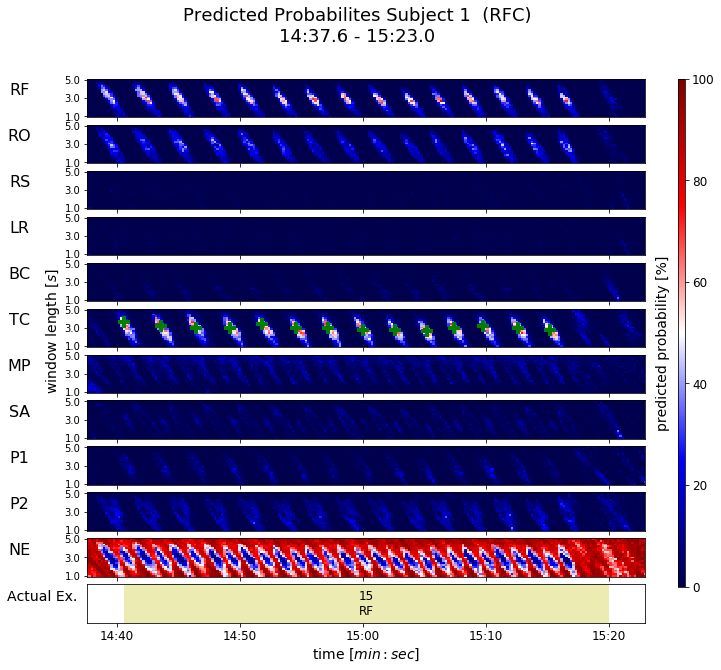

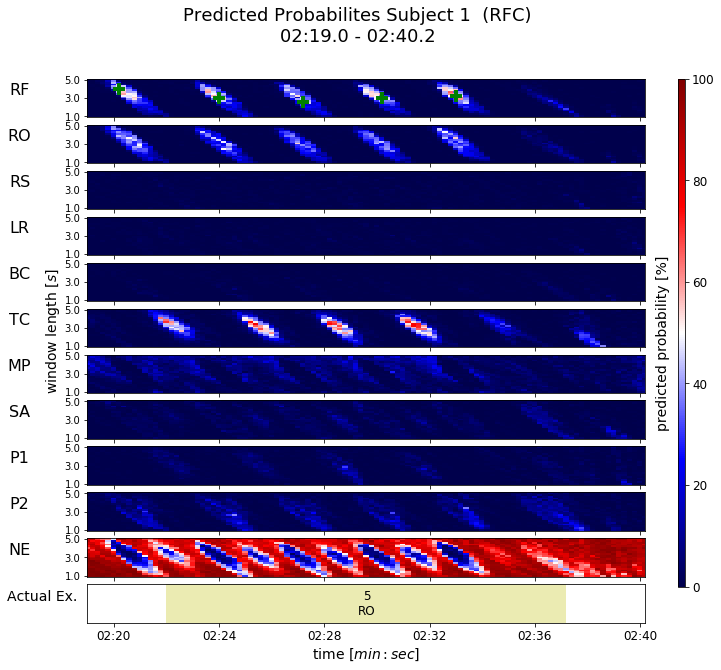

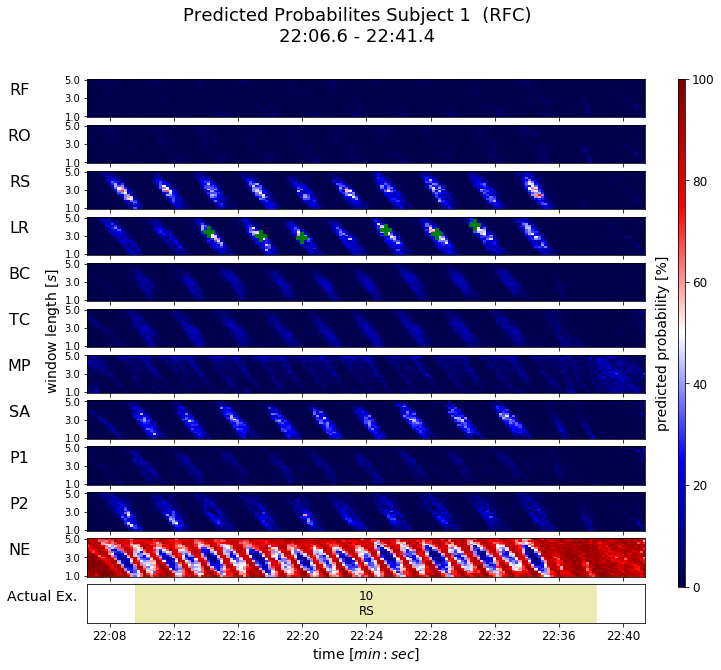

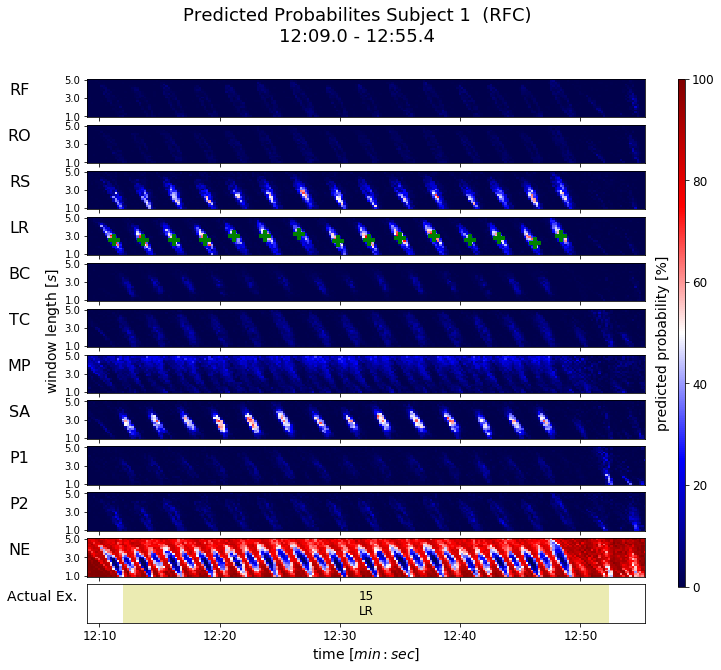

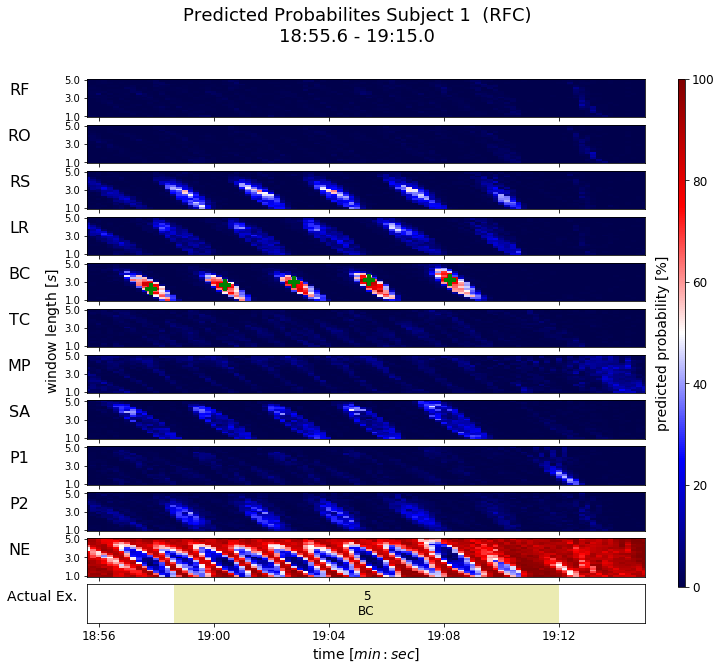

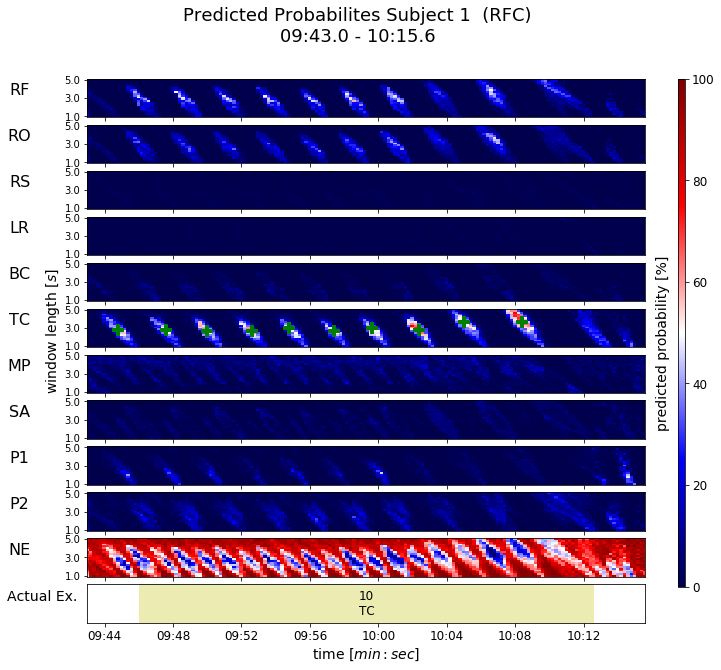

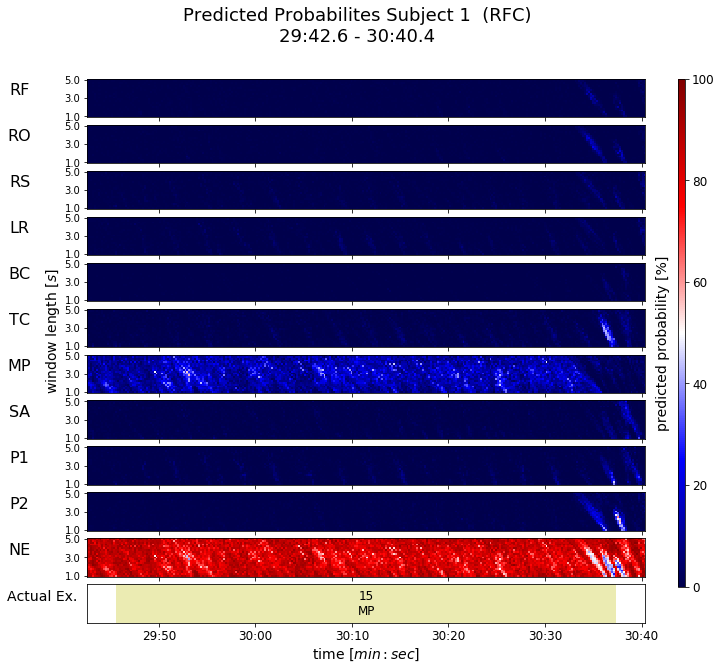

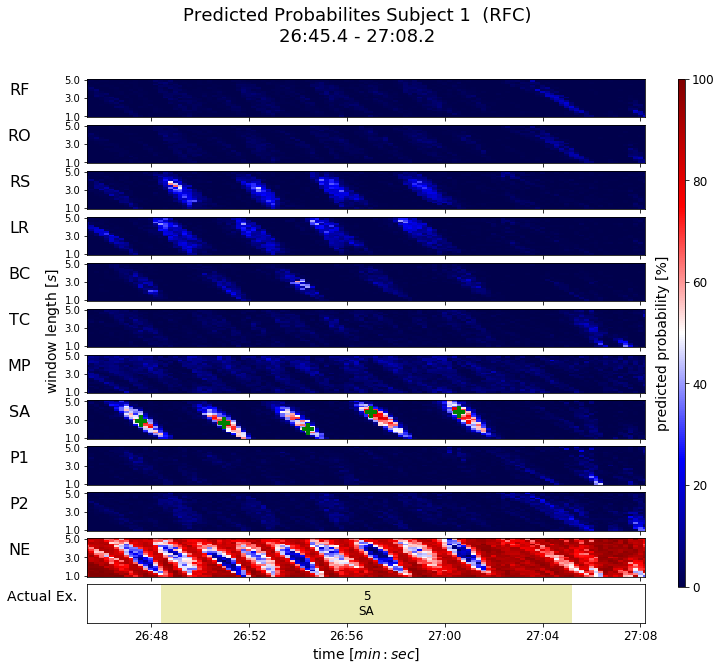

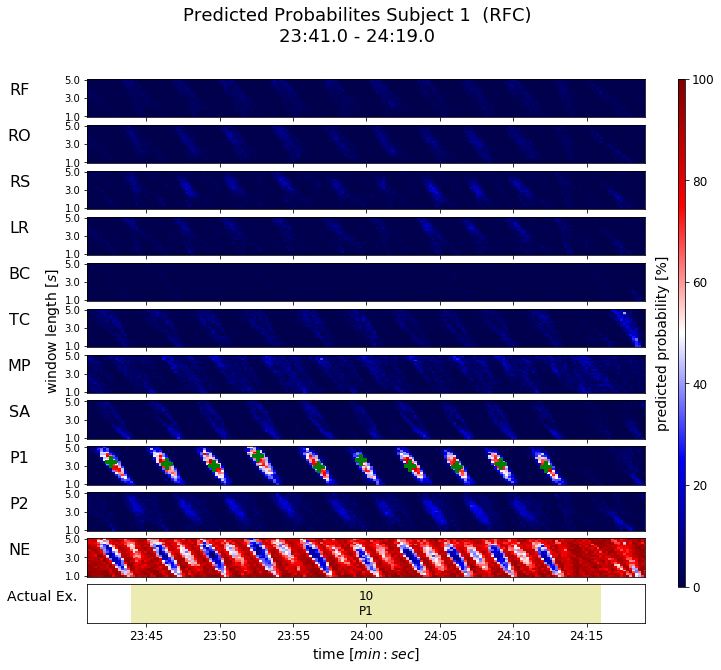

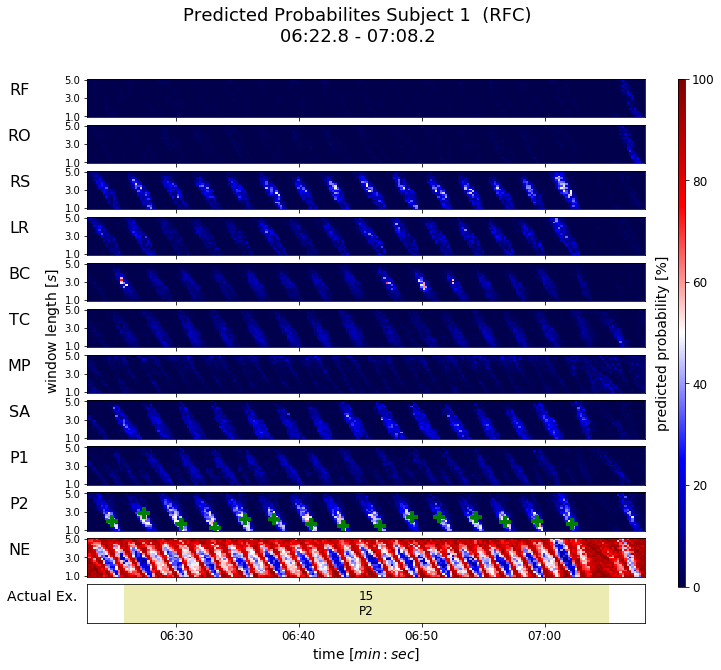

In [63]:
for ex_rep_block in plot_exercise_repetition_blocks:
    DataObject_WinProc.plot_probability_matrices_and_peaks(title_text='Predicted Probabilites Subject {}  ({})'.format(
                                           test_subject_id, ML_model_name),
                                           default_settings_smaller_plot=True,
                                           plot_time_range=True,
                                           start_time=timetable_ex_dict[ex_rep_block+'_start_time'],
                                           stop_time=timetable_ex_dict[ex_rep_block+'_stop_time'],
                                           time_offset_before_and_after=plot_time_offset_before_and_after,
                                           plot_actual_classes=True,
                                           timetable_file_dir=timetable_file_dir,
                                           timetable_file_name=timetable_file_name)

***
***
***
***
***

## Function to Print Evaluation Summary

In [64]:
def print_eval_summary():
    '''
    Function to print evaluation summary.
    
    No parameters, no returns (global variables are used).
    '''
    
    print('\n    Summary of Evaluation Report\n')

    print('Test data set:')
    print('\tSubject ID: \t{}'.format(test_subject_id))
    print('\tSamples: \t{}'.format(np.shape(DataObj.X_test())[0]))
    print('\tRep. num.: \t{}'.format(test_repetition_numbers))
    print('\tExercises: \t{}'.format(test_exercises))
    print('\tRotation axes: \t{}'.format(rot_axis_test_data))
    print('\tRot. angles: \t{}'.format(rot_angle_test_data))
    if add_noise_test_data:
        print('\tSNR: \t\t{} db'.format(snr_db))
    else:
        print('\tSNR: \t\tnone')

    print('\nTrain data set:')
    print('\tSubject ID(s): \t{}'.format(train_subject_ids))
    print('\tSamples: \t{}'.format(np.shape(DataObj.X_train())[0]))
    print('\tRep. num.: \t{}'.format(train_repetition_numbers))
    print('\tExercises: \t{}'.format(train_exercises))
    if add_noise_train_data:
        print('\tSNR: \t{} db'.format(snr_db))
    else:
        print('\tSNR: \t\tnone')

    print('\nNumber of sections to split each rep.: {}'.format(number_sections))

    if use_PCA_for_dim_reduction is True:
        print('\nDimensionality reduction: \tPCA ({} PCs)'.format(number_principal_components))
    if use_LDA_for_dim_reduction is True:
        print('\nDimensionality reduction: \tLDA')
    if use_PCA_for_dim_reduction is False and use_LDA_for_dim_reduction is False:
        print('\nDimensionality reduction: \tnone')

    print('\nParameters for windowing procedure:')
    print('\tWin. start inc.: \t{} s'.format(win_start_inc))
    print('\tWin. stretch inc.: \t{} s'.format(win_stretch_inc))
    print('\tMin. win. length: \t{} s'.format(win_min_len))
    print('\tMax. win. length: \t{} s'.format(win_max_len))
    print('\tFilter order: \t\t{}'.format(butterworth_order))  
    print('\tCutoff frequency: \t{} Hz'.format(butterworth_cutoff)) 

    print('\nParameters for windowing procedure:')
    print('\tMax. time betw. 2 rep.:\t{} s'.format(max_time_between_peaks))
    print('\tMin rep. per block: \t{}'.format(min_peaks_per_block))
    print('\tProb. threshold: \t{}'.format(threshold_prob))
    print('\tFootprint length: \t{} s'.format(footprint_length))

    print('\nMachine Learning:')
    print('\tModel: \t{}'.format(ML_model_name))
    print('\tParam. for grid search cross val.:')
    for param in param_grid:
        print('\t\t{}: {}'.format(param, param_grid[param]))
    print('\tBest parameters:')    
    for param in grid_search.best_params_:
        print('\t\t{}: {}'.format(param, grid_search.best_params_[param]))
    print('\tBest score (gridsearchCV): \t{:.2f}%'.format(grid_search.best_score_*100))
    print('\n\tScore on sep. test samples: \t{:.2f}%\n'.format((accuracy_score(DataObj.y_test(), y_pred))*100))
    print('\tExerc.\tPrec.\tRecall\tF1-Sc.\tSupport')
    for ex in ['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2','NE']:
        print('\t{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:7d}'.format(ex, classif_report[ex]['precision'], 
                                                          classif_report[ex]['recall'],
                                                          classif_report[ex]['f1-score'], 
                                                          classif_report[ex]['support']))
    print('\t{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:7d}'.format('total', classif_report['micro avg']['precision'], 
                                                          classif_report['micro avg']['recall'],
                                                          classif_report['micro avg']['f1-score'], 
                                                          classif_report['micro avg']['support']))


***Execute the cell with the evaluation summary:***

In [65]:
%%javascript
Jupyter.notebook.execute_cells([1])

<IPython.core.display.Javascript object>